In [1]:
import tensorflow as tf 
import os 
import numpy as np 
from google.colab import drive 

SEED= 10714338
tf.random.set_seed(SEED)

cwd= os.getcwd() #get current working directory 

In [2]:

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

!ls /content/

drive  sample_data


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

apply_data_augmentation  = True

if  apply_data_augmentation:
  train_datagen = ImageDataGenerator(             #this data augmentation is gonna modify the images at each epoch 
  width_shift_range = 0.2, 
  height_shift_range = 0.2,
  vertical_flip=True,shear_range = 0.2,
  fill_mode='constant',
  cval=0,
  rescale=1/255.)
  
else:
  train_datagen = ImageDataGenerator(rescale=1/255.)

valid_datagen = ImageDataGenerator(rescale= 1/255.)
test_datagen= ImageDataGenerator(rescale= 1/255.)

#datagen = ImageDataGenerator(
 #       rotation_range=40,
  #      width_shift_range=0.2,
   #     height_shift_range=0.2,
    #    rescale=1./255,
     #   shear_range=0.2,
      #  ,
       # horizontal_flip=True,
        #fill_mode='nearest')

In [6]:
#now I need to get the test images and associate them to the label contained in the json file 
import pandas as pd
import json
import sklearn


json_path=os.path.join(cwd,'drive','My Drive','AN2DL_HW_1','MaskDataset')

with open(os.path.join(json_path,"train_gt.json")) as j:
  tmp = json.load(j)

train_df = pd.DataFrame(tmp.items())
train_df.rename(columns = {0:'filename', 1:'class'}, inplace = True)
train_df["class"] = train_df["class"].astype(str)

train_df_shuffled=sklearn.utils.shuffle(train_df) #here we could divide the dataset in training and validation

training_df= train_df_shuffled[614:]
validation_df= train_df_shuffled[:614]

print(validation_df,training_df)

       filename class
4013  10447.jpg     2
1883  17384.jpg     0
5120  12569.jpg     2
3503  16917.jpg     1
5610  11787.jpg     2
...         ...   ...
2038  16332.jpg     1
1460  14260.jpg     0
43    12834.jpg     0
486   13745.jpg     0
2969  16893.jpg     1

[614 rows x 2 columns]        filename class
112   12908.jpg     0
3780  16577.jpg     1
192   14667.jpg     0
1177  17274.jpg     0
1553  11846.jpg     0
...         ...   ...
931   16109.jpg     0
4696  10552.jpg     2
2705  16834.jpg     1
2547  15659.jpg     1
479   10834.jpg     0

[5000 rows x 2 columns]


In [7]:
#Let's create the generators 

directory_training =os.path.join(cwd,'drive','My Drive','AN2DL_HW_1','MaskDataset','training')


bs = 10

train_generator=train_datagen.flow_from_dataframe(
dataframe=training_df,
directory=directory_training,
x_col="filename",
y_col="class",
batch_size=bs,
seed=SEED,
shuffle=True,
target_size=(256, 256),
class_mode="categorical",
)

valid_generator=valid_datagen.flow_from_dataframe(
dataframe=validation_df,
directory=directory_training,
x_col="filename",
y_col="class",
batch_size=bs,
seed=SEED,
shuffle=True,
target_size=(256, 256),
class_mode="categorical",
)


Found 5000 validated image filenames belonging to 3 classes.
Found 614 validated image filenames belonging to 3 classes.


In [8]:
num_classes=3
img_h=256
img_w=256


train_dataset= tf.data.Dataset.from_generator(lambda:train_generator,
                                              (tf.float32, tf.float32),
                                              ([None,img_h,img_w,3],[None,num_classes])) 

train_dataset=train_dataset.repeat()

validation_dataset= tf.data.Dataset.from_generator(lambda:valid_generator,
                                              (tf.float32, tf.float32),
                                              ([None,img_h,img_w,3],[None,num_classes]))


validation_dataset=validation_dataset.repeat()


[]

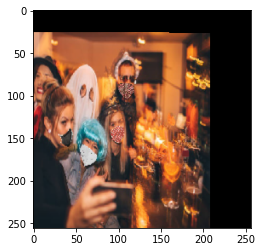

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

iterator= iter(train_dataset)

img , target = next(iterator)

img= np.array(img[0])
img=img *255
plt.imshow(np.uint8(img))
plt.plot()

[]

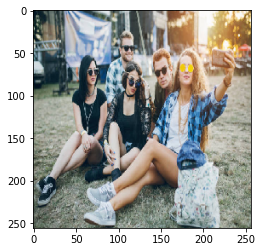

In [10]:
%matplotlib inline

iterator= iter(validation_dataset)

img , target = next(iterator)

img= np.array(img[0])
img=img *255
plt.imshow(np.uint8(img))
plt.plot()

In [12]:
#create the network recursively and with a for loop stack layers one on top of the other   
#strat_f=10 and depth=6 around 70 percent accuracy

#strat_f = 10 and depth = 6 gave me 0.74 score
#epoch size was 25
#batch size was 10
# I also added some other parameters to data generator function
#if  apply_data_augmentation:
  #train_datagen = ImageDataGenerator(               #this data augmentation is gonna modify the images at each epoch 
  #width_shift_range = 0.2, rotation_range = 40, 
  #height_shift_range = 0.2,zoom_range = 0.2,
  #vertical_flip=True,shear_range = 0.2,
  #fill_mode='nearest',
  #cval=0,
  #rescale=1/255.)
  
start_f = 40 # starting number of features  to be increased as we go deeper in the network  
depth = 5 #depth of my feature extractor

model=tf.keras.Sequential()

for i in range(depth):  
  if i== 0:  
     input_shape=[img_h,img_w,3]
  else:
    input_shape=[None]

  model.add(tf.keras.layers.Conv2D(filters=start_f,       #first layer is convolutional 
                                  kernel_size=(3,3),
                                  strides=(1,1),        #kernel shifted of one postion at time
                                  padding='same',
                                  input_shape=input_shape))
    
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.ReLU()) #activation layer 
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) #maxpooling 
  start_f=start_f*2
    


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=num_classes,activation='softmax'))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 40)      1120      
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 40)      160       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 256, 256, 40)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 40)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 80)      28880     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 128, 80)      320       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 128, 128, 80)     

In [14]:
loss= tf.keras.losses.CategoricalCrossentropy()

lr= 1e-4

optimizer= tf.keras.optimizers.Adam(learning_rate=lr)

metrics=['accuracy']

model.compile(optimizer=optimizer,loss=loss,metrics=metrics )

In [18]:
#lets do early stopping callback 

callbacks=[]

es_callback= tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 5) 
callbacks.append(es_callback)


model.fit(x=train_dataset, 
          epochs=25,  #max number of epoch 
          steps_per_epoch=len(train_generator),
          validation_data= validation_dataset, 
          validation_steps=len(valid_generator),
          callbacks=callbacks )

Epoch 1/25
500/500 [==============================] - 125s 250ms/step - loss: 0.6309 - accuracy: 0.6974 - val_loss: 0.6910 - val_accuracy: 0.6678
Epoch 2/25
500/500 [==============================] - 125s 251ms/step - loss: 0.6168 - accuracy: 0.7056 - val_loss: 0.6230 - val_accuracy: 0.7068
Epoch 3/25
500/500 [==============================] - 126s 251ms/step - loss: 0.6043 - accuracy: 0.7134 - val_loss: 0.6588 - val_accuracy: 0.6840
Epoch 4/25
500/500 [==============================] - 126s 252ms/step - loss: 0.5844 - accuracy: 0.7240 - val_loss: 0.5719 - val_accuracy: 0.7410
Epoch 5/25
500/500 [==============================] - 125s 249ms/step - loss: 0.5691 - accuracy: 0.7342 - val_loss: 0.5442 - val_accuracy: 0.7524
Epoch 6/25
500/500 [==============================] - 124s 248ms/step - loss: 0.5596 - accuracy: 0.7280 - val_loss: 0.5455 - val_accuracy: 0.7492
Epoch 7/25
500/500 [==============================] - 123s 247ms/step - loss: 0.5640 - accuracy: 0.7300 - val_loss: 0.9406 -

In [19]:
 test_dir =os.path.join(cwd,'drive','My Drive','AN2DL_HW_1','MaskDataset','test')

test_gen = test_datagen.flow_from_directory(test_dir, target_size=(img_h, img_w), 
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 classes = None,
                                                 batch_size=1,
                                                 shuffle=False)
test_gen.reset()

predictions = model.predict_generator(test_gen, len(test_gen), verbose=1)


from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

results = {}
images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1
  
create_csv(results, '/content/drive/My Drive/AN2DL_HW_1')

Found 450 images belonging to 1 classes.
450/450 [==============================] - 4s 9ms/step
